In [4]:
import torch
from lmul_nn_funcs import lmul_bits 
def lmul(a, b, M=7):
    return lmul_bits(a, b)

#this is the dataset loader
#this is used for regressive generation;

#needed heavy LLM help to build this notebook out
class CharDatasetFixed(torch.utils.data.Dataset):
    def __init__(self, sentences, pad_char=" ", seq_len=64):
        self.pad_char = pad_char
        self.seq_len = seq_len

        # include pad_char explicitly
        all_text = "".join(sentences) + pad_char
        chars = sorted(list(set(all_text)))   # now pad_char is in chars
        self.stoi = {c:i for i,c in enumerate(chars)}
        self.itos = {i:c for c,i in self.stoi.items()}
        self.vocab = len(chars)

        # convert sentences to indices and pad
        self.data = []
        for s in sentences:
            s_fixed = s[:seq_len].ljust(seq_len, pad_char)
            self.data.append(torch.tensor([self.stoi[c] for c in s_fixed]))


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        s = self.data[idx]
        x = s[:-1]  # input sequence
        y = s[1:]   # target = next character
        return x, y



In [2]:
import sys
sys.path.append('../rtl')

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
class LSTMLayerLMUL(nn.Module):
    def __init__(self, input_size, hidden_size, use_lmul=False, M=7):
        super().__init__()
        self.hidden_size = hidden_size
        self.use_lmul = use_lmul
        self.M = M
        self.W = nn.Linear(input_size + hidden_size, 4*hidden_size)

    def forward(self, x_t, h_prev, c_prev):
        combined = torch.cat((x_t, h_prev), dim=1)

        if self.use_lmul:
            W = self.W.weight
            b = self.W.bias
            B, I = combined.shape
            O, _ = W.shape
            prod = lmul(combined.unsqueeze(1), W.unsqueeze(0), M=self.M)
            gates = prod.sum(dim=2) + b
        else:
            gates = self.W(combined)

        i, f, g, o = torch.chunk(gates, 4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        if self.use_lmul:
            c_t = lmul(f, c_prev, M=self.M) + lmul(i, g, M=self.M)
            h_t = lmul(o, torch.tanh(c_t), M=self.M)
        else:
            c_t = f * c_prev + i * g
            h_t = o * torch.tanh(c_t)

        return h_t, c_t


In [6]:
class TinyLMUL_LLM(nn.Module):
    def __init__(self, vocab, hidden=128, use_lmul=False, M=7):
        super().__init__()
        self.hidden_size = hidden
        self.use_lmul = use_lmul

        self.embed = nn.Embedding(vocab, hidden)
        self.lstm = LSTMLayerLMUL(hidden, hidden, use_lmul, M)
        self.fc = nn.Linear(hidden, vocab)

    def forward(self, x):
        B, T = x.size()
        h = torch.zeros(B, self.hidden_size)
        c = torch.zeros(B, self.hidden_size)

        for t in range(T):
            x_t = self.embed(x[:, t])
            h, c = self.lstm(x_t, h, c)

        logits = self.fc(h)
        return logits


In [7]:
def train(model, loader, epochs=5, lr=3e-4):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total = 0
        for x, y in loader:
            opt.zero_grad()
            logits = model(x)

            loss = F.cross_entropy(logits, y[:, -1])
            loss.backward()
            opt.step()

            total += loss.item()

        print(f"Epoch {epoch+1}, loss={total/len(loader):.4f}")


In [8]:
@torch.no_grad()
def generate(model, dataset, start="A", length=200, temperature=1.0):
    model.eval()

    chars = [dataset.stoi[c] for c in start]
    h = torch.zeros(1, model.hidden_size)
    c = torch.zeros(1, model.hidden_size)
    # prime with prefix
    for ch in chars:
        x_t = model.embed(torch.tensor([ch]))
        h, c = model.lstm(x_t, h, c)

    out = start
    token = chars[-1]

    for _ in range(length):
        logits = model.fc(h) / temperature
        probs = torch.softmax(logits, dim=-1)
        token = torch.multinomial(probs, num_samples=1).item()

        out += dataset.itos[token]

        x_t = model.embed(torch.tensor([token]))
        h, c = model.lstm(x_t, h, c)

    return out


In [9]:
import requests

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
text = requests.get(url).text
sentences = text.split("\n")
new_sentences = []
for i in range(0, len(sentences), 5):
    #every 5 sentences, I merge
    new_sentences.append("\n".join(sentences[i:i+5]))
                    


In [10]:
len(new_sentences)

8001

In [11]:
#we dont need to run this cell anymore; its JUST for trainin and we save the weights anyways
dataset = CharDatasetFixed(new_sentences[0:1000], pad_char=" ", seq_len=128)
loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)



#Standard FP32 LSTM (we dont use LMUL to train because gradienting using operations in LMUL is crazy cringe and not possible)
model_fp32 = TinyLMUL_LLM(dataset.vocab, hidden=128, use_lmul=False)
train(model_fp32, loader, epochs=10)

#Save the FP32 weights
torch.save(model_fp32.state_dict(), "tiny_llm_fp32.pth")

Epoch 1, loss=1.5726
Epoch 2, loss=1.2334
Epoch 3, loss=1.1032
Epoch 4, loss=1.0050
Epoch 5, loss=0.9164
Epoch 6, loss=0.8370
Epoch 7, loss=0.7588
Epoch 8, loss=0.6837
Epoch 9, loss=0.6058
Epoch 10, loss=0.5381


In [12]:
prompt = "Exquisite"
print(generate(model_fp32, dataset, start=prompt, length=300, temperature=0.01))

Exquisite fre sastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare


In [13]:
model_lmul = TinyLMUL_LLM(dataset.vocab, hidden=128, use_lmul=True)

#Load the FP32-trained weights, but we use the LSTM with LMUL operation
model_lmul.load_state_dict(torch.load("tiny_llm_fp32.pth"))
model_lmul.eval()

TinyLMUL_LLM(
  (embed): Embedding(61, 128)
  (lstm): LSTMLayerLMUL(
    (W): Linear(in_features=256, out_features=512, bias=True)
  )
  (fc): Linear(in_features=128, out_features=61, bias=True)
)

In [14]:
lmul_text = generate(model_lmul, dataset, start=prompt, length=300, temperature=0.01)
print("\nLMUL LSTM output:\n", lmul_text)


LMUL LSTM output:
 Exquisite fre sastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare ssastare


In [18]:
import numpy as np

In [19]:
train_sentences = new_sentences[0:1000]
test_sentences = new_sentences[1000:1500]

test_dataset = CharDatasetFixed(test_sentences, pad_char=" ", seq_len=128)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False)

print(f"Train size: {len(train_sentences)}")
print(f"Test size: {len(test_sentences)}")

Train size: 1000
Test size: 500


In [20]:
@torch.no_grad()
def calculate_perplexity(model, loader):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    
    for x, y in loader:
        B, T = x.size()
        h = torch.zeros(B, model.hidden_size)
        c = torch.zeros(B, model.hidden_size)
        
        losses = []
        for t in range(T):
            x_t = model.embed(x[:, t])
            h, c = model.lstm(x_t, h, c)
            logits = model.fc(h)
            
            loss = F.cross_entropy(logits, y[:, t], reduction='sum')
            losses.append(loss.item())
            total_tokens += B
        
        total_loss += sum(losses)
    
    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)
    
    return perplexity, avg_loss

In [21]:
fp32_perplexity, fp32_loss = calculate_perplexity(model_fp32, test_loader)
print(f"FP32 Perplexity: {fp32_perplexity:.2f}")

lmul_perplexity, lmul_loss = calculate_perplexity(model_lmul, test_loader)
print(f"LMUL Perplexity: {lmul_perplexity:.2f}")

perplexity_pct = (lmul_perplexity - fp32_perplexity) / fp32_perplexity * 100
print(f"Difference: {perplexity_pct:+.2f}%")

FP32 Perplexity: 20.59
LMUL Perplexity: 21.85
Difference: +6.10%


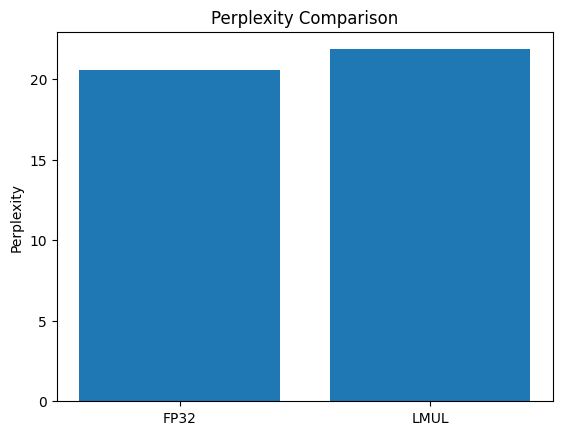

In [23]:
import matplotlib.pyplot as plt
perplexities = [fp32_perplexity, lmul_perplexity]
plt.bar(['FP32', 'LMUL'], perplexities)
plt.ylabel('Perplexity')
plt.title('Perplexity Comparison')
plt.savefig('perplexity.png')
plt.show()